 # 📌 Feature Engineering – Framingham Heart Study (10-Year CHD Risk)

In this notebook, I transform the cleaned Framingham dataset into a modeling-ready dataset by:

- verifying data quality,

- transforming skewed clinical variables,

- creating domain-informed features,

- exporting the final feature set.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use("default")
sns.set()

In [2]:
df = pd.read_csv('cleaned_heart.csv')
print("Data loaded. Shape:", df.shape)
df.head()

Data loaded. Shape: (4240, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Data structure & missing values

Check column types and confirm there are no missing values left from the cleaning step.

In [3]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4240 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4240 non-null   float64
 5   BPMeds           4240 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4240 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4240 non-null   float64
 13  heartRate        4240 non-null   float64
 14  glucose          4240 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

## Skewness of numerical features

We identify skewed variables to decide where transformations (like log1p) are needed.

In [5]:
numerical_features = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
df[numerical_features].skew().sort_values(ascending=False)

glucose      6.542928
sysBP        1.145285
BMI          0.985646
totChol      0.879159
diaBP        0.713250
heartRate    0.644498
age          0.228867
dtype: float64

#### glucose & sysBP skewed!

## Log transformation

We apply a log1p transformation to highly right-skewed variables (sysBP, glucose) to reduce the influence of extreme values.

In [7]:
skewed_to_log = ['sysBP', 'glucose']
for col in skewed_to_log:
    df[col] = np.log1p(df[col])


## Age and BMI risk categories

We create clinically interpretable categories before scaling:

Age groups based on decades.

BMI groups based on WHO cutoffs.

🔎 This is a correction: binning is now based on real-world values (years, kg/m²), not scaled scores.

In [9]:
# Age groups in years
df['age_group'] = pd.cut(
    df['age'],
    bins=[29, 40, 50, 60, 80],
    labels=['30-39', '40-49', '50-59', '60+'],
    include_lowest=True
)

# BMI categories based on WHO
df['BMI_category'] = pd.cut(
    df['BMI'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
    include_lowest=True
)


## Feature scaling

We standardize continuous numerical variables to mean 0 and standard deviation 1 for models that are sensitive to scale (e.g. Logistic Regression, SVM).

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


## Domain-informed feature engineering

We create additional features relevant to cardiovascular risk:

- bp_diff: pulse pressure (difference between systolic and diastolic)

- age_sysBP: interaction between age and blood pressure

- BMI_glucose: interaction between BMI and glucose

In [13]:
# Pulse pressure
df['bp_diff'] = df['sysBP'] - df['diaBP']

# Interaction: age × systolic blood pressure
df['age_sysBP'] = df['age'] * df['sysBP']

# Interaction: BMI × glucose
df['BMI_glucose'] = df['BMI'] * df['glucose']

df[['bp_diff', 'age_sysBP', 'BMI_glucose']].head()



,bp_diff,age_sysBP,BMI_glucose
0,-0.264298,1.662981,-0.048638
1,-0.322292,0.201167,-0.171971
2,0.098803,0.026642,0.076827
3,-0.131591,1.178541,0.918261
4,-0.112695,0.008412,-0.234326


## Correlation matrix

We inspect correlations between features (including engineered ones) and the target to understand relationships and check for redundancy.

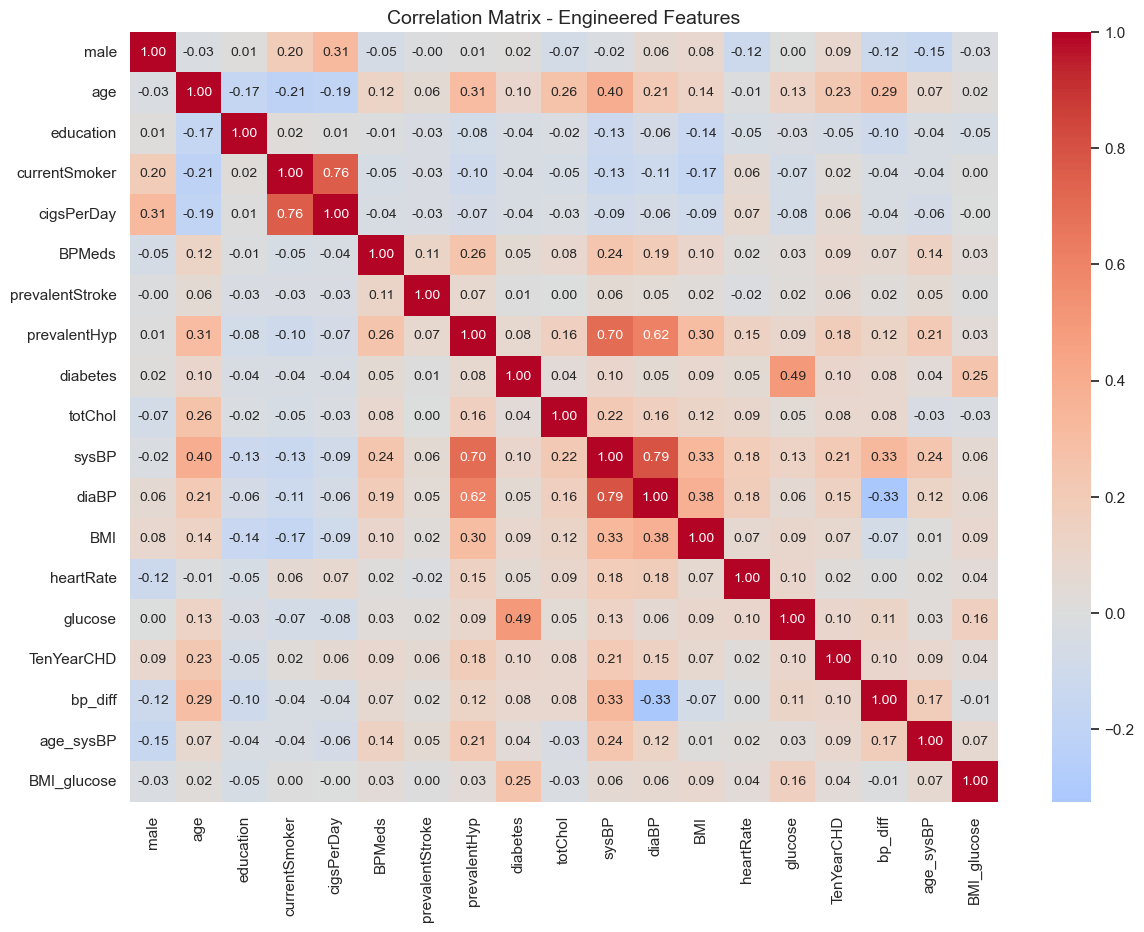

In [23]:
plt.figure(figsize=(14,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0,annot=True,fmt='.2f',annot_kws={"size":10})
plt.title("Correlation Matrix - Engineered Features",fontsize=14)
plt.show()


In [24]:
corr_abs = df.corr().abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

high_corr_features = [col for col in upper.columns if any(upper[col] > 0.9)]
print("Highly correlated features (> 0.9):", high_corr_features)


Highly correlated features (> 0.9): []


## Export

We save the final feature-engineered dataset for the modeling n

In [25]:
df.to_csv("framingham_feature_engineered.csv", index=False)
print("Saved: framingham_feature_engineered.csv")


Saved: framingham_feature_engineered.csv
